# [Final] AUDIO classifier model

In [1]:
#base libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#for data loading:
import os
import glob
#for preprocessing - augmentation:
import tensorflow as tf
import tensorflow_io as tfio
from keras.utils import  to_categorical 
from keras.preprocessing.image import ImageDataGenerator
#for model:
from tensorflow.keras.models import Sequential 
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, MaxPool2D, Dropout, LSTM, Input
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
#for loading models:
from keras.models import Model
#custom weights:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
#for evaluation:
from sklearn.metrics import confusion_matrix

#### Function to load in audio files:

In [2]:
def load_wav_data(x): #process audio to 16000Hz convert to single channel!:
    file = tf.io.read_file(x)
    #decode wav (tensors by channels):
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    #remove trailing axis:
    wav = tf.squeeze(wav, axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) #from 441000 to 16000Hz
    return wav

## Audio preprocessing - Spectrogram:

#### gain factor is used for amplification of the audio waveforms:

In [3]:
def preprocess(file_path, label, gain_factor=1.5): 
    wav = load_wav_data(file_path)
    wav = wav[:160000] #max length
    wav = tf.concat([wav], 0)
    wav = wav * gain_factor #amplification
    #reduced frame length and increased step size for faster computation:
    spectrogram = tf.signal.stft(wav, frame_length=256, frame_step=128) #320 #32
    spectrogram = tf.abs(spectrogram) #get rid of negatives
    spectrogram = tf.expand_dims(spectrogram, axis=2) #gray scale image
    return spectrogram, label

### load  audio test files:

In [4]:
home_2 = tf.data.Dataset.list_files('AUDIO/home'+'\*.wav') #312 files
office_2 = tf.data.Dataset.list_files('AUDIO/office'+'\*.wav')
store_2 = tf.data.Dataset.list_files('AUDIO/store'+'\*.wav')
restaurant_2 = tf.data.Dataset.list_files('AUDIO/restaurant'+'\*.wav')
library_2 = tf.data.Dataset.list_files('AUDIO/library'+'\*.wav')
subway_2 = tf.data.Dataset.list_files('AUDIO/subway'+'\*.wav')

In [5]:
lib_array_2 = tf.constant(2.0, dtype='float32', shape=10) 
res_array_2 = tf.constant(3.0, dtype='float32', shape=10)
sto_array_2 = tf.constant(4.0, dtype='float32', shape=10)
sub_array_2 = tf.constant(5.0, dtype='float32', shape=10)

lib_2 = tf.data.Dataset.zip((library_2, tf.data.Dataset.from_tensor_slices(lib_array_2)))
res_2 = tf.data.Dataset.zip((restaurant_2, tf.data.Dataset.from_tensor_slices(res_array_2)))
sto_2 = tf.data.Dataset.zip((store_2, tf.data.Dataset.from_tensor_slices(sto_array_2)))
sub_2 = tf.data.Dataset.zip((subway_2, tf.data.Dataset.from_tensor_slices(sub_array_2)))
home_3 = tf.data.Dataset.zip((home_2, tf.data.Dataset.from_tensor_slices(tf.zeros(len(home_2)))))
office_3 = tf.data.Dataset.zip((office_2, tf.data.Dataset.from_tensor_slices(tf.ones(len(office_2)))))

audio_data_test = home_3.concatenate(office_3).concatenate(lib_2).concatenate(res_2).concatenate(sto_2).concatenate(sub_2)

In [6]:
audio_data_test = audio_data_test.map(preprocess)
audio_data_test = audio_data_test.cache()
audio_data_test = audio_data_test.shuffle(buffer_size=1000)
audio_data_test = audio_data_test.batch(16)
audio_data_test = audio_data_test.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### loading train+validation sets:

take random 100 audio:

In [7]:
home = tf.data.Dataset.list_files('AUDIO_ALL/home'+'\*.wav').shuffle(1000).take(100)  #312 files
office = tf.data.Dataset.list_files('AUDIO_ALL/office'+'\*.wav').shuffle(1000).take(100) 
store = tf.data.Dataset.list_files('AUDIO_ALL/store'+'\*.wav').shuffle(1000).take(100) 
restaurant = tf.data.Dataset.list_files('AUDIO_ALL/restaurant'+'\*.wav').shuffle(1000).take(100) 
library = tf.data.Dataset.list_files('AUDIO_ALL/library'+'\*.wav').shuffle(1000).take(100) 
subway = tf.data.Dataset.list_files('AUDIO_ALL/subway'+'\*.wav').shuffle(1000).take(100) 

create labels:

In [8]:
lib_array = tf.constant(2.0, dtype='float32', shape=100) 
res_array = tf.constant(3.0, dtype='float32', shape=100)
sto_array = tf.constant(4.0, dtype='float32', shape=100)
sub_array = tf.constant(5.0, dtype='float32', shape=100)

lib = tf.data.Dataset.zip((library, tf.data.Dataset.from_tensor_slices(lib_array)))
res = tf.data.Dataset.zip((restaurant, tf.data.Dataset.from_tensor_slices(res_array)))
sto = tf.data.Dataset.zip((store, tf.data.Dataset.from_tensor_slices(sto_array)))
sub = tf.data.Dataset.zip((subway, tf.data.Dataset.from_tensor_slices(sub_array)))
home_4 = tf.data.Dataset.zip((home, tf.data.Dataset.from_tensor_slices(tf.zeros(len(home)))))
office_4 = tf.data.Dataset.zip((office, tf.data.Dataset.from_tensor_slices(tf.ones(len(office)))))

audio_data = home_4.concatenate(office_4).concatenate(lib).concatenate(res).concatenate(sto).concatenate(sub)

In [9]:
audio_data = audio_data.map(preprocess)
audio_data = audio_data.cache()
audio_data = audio_data.shuffle(buffer_size=1000)
audio_data = audio_data.batch(16)
audio_data = audio_data.prefetch(8)

#### Split into train+validation sets:

In [10]:
train_size = int(len(audio_data)*.8) 
val_size = int(len(audio_data)*.2)  

In [11]:
print(train_size, val_size) #train and validation batch sizes:

30 7


In [12]:
audio_train = audio_data.take(train_size) #define how much data we take - batch size ofc.
audio_val = audio_data.skip(train_size).take(val_size)

#### OneHotencoding for the labels:

In [13]:
audio_Y_train = np.concatenate([y for x, y in audio_train], axis=0)
audio_X_train = np.concatenate([x for x, y in audio_train], axis=0)

audio_Y_val = np.concatenate([y for x, y in audio_val], axis=0)
audio_X_val = np.concatenate([x for x, y in audio_val], axis=0)

audio_Y_test2 = np.concatenate([y for x, y in audio_data_test], axis=0)
audio_X_test2 = np.concatenate([x for x, y in audio_data_test], axis=0)

In [14]:
#samples, labels = audio_val.as_numpy_iterator().next()
#samples.shape

(16, 1249, 129, 1)

In [15]:
audio_Y_train_cat = to_categorical(audio_Y_train)
audio_Y_val_cat = to_categorical(audio_Y_val)
audio_Y_test2_cat = to_categorical(audio_Y_test2)

## data augmentation: 

In [16]:
audio_train_datagen = ImageDataGenerator(
)
audio_train_datagen.fit(audio_X_train)

audio_train_generator = audio_train_datagen.flow(
    audio_X_train,
    audio_Y_train_cat,
    batch_size = 16)

#### for validation + test:

In [17]:
audio_val_generator = ImageDataGenerator().flow(
    audio_X_val,
    audio_Y_val_cat,
    batch_size = 16)

In [19]:
audio_test_generator2 = ImageDataGenerator().flow(
    audio_X_test2,
    audio_Y_test2_cat,
    batch_size = 8)

# AUDIO-classification model:

In [22]:
model = Sequential()
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(1249, 129, 1))) #4991 #2491
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

## model summary:

In [23]:
model.compile('Adam', loss='categorical_crossentropy',  metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1247, 127, 128)    1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 623, 63, 128)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 621, 61, 64)       73792     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 310, 30, 64)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 310, 30, 64)      256       
 ormalization)                                                   
                                                      

### early stopping:

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>0.95):
            print('\nReached 95+%, so canceling training')
            self.model.stop_training = True

In [ ]:
hist = model.fit(audio_train_generator, epochs=20, 
                  validation_data=audio_val_generator,  #step size is 30
                  callbacks=myCallback())

## model evaluation:

#### plot accuracy + loss:

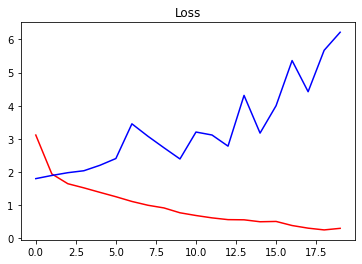

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

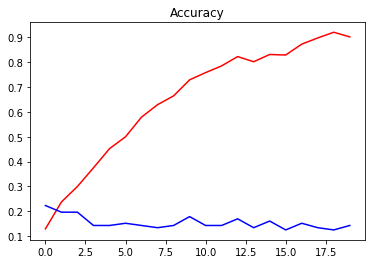

In [27]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [28]:
model.evaluate_generator(generator=audio_test_generator2)

C:\Users\revie\AppData\Local\Temp\ipykernel_14840\3492524436.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(generator=audio_test_generator2)


[5.160716533660889, 0.20000000298023224]

We can see through model training that 2 categories it  struggles the most with are office and store.

#### save model:

In [30]:
model.save('models/AudioClass_2048.h5')

#### load model:

In [ ]:
#model = tf.keras.models.load_model('AudioClass_537.h5')

#### confusion matrix (test):

In [ ]:
#for white background.. but nod needed if you save the plot!
#import matplotlib.style
#import matplotlib as mpl
#mpl.style.use('classic')

In [ ]:
test_pred = model.predict(audio_X_test2)
test_predicted = np.argmax(test_pred, axis = 1)
test_true = np.argmax(audio_Y_test2_cat, axis = 1)
confmx = confusion_matrix(test_predicted, test_true)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax, cmap='Blues')
#set title + labels:
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of the Audio Classifier model')
#set tick labels:
labels = ['home', 'library', 'office', 'cafe', 'store', 'metro']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.savefig('CF_audio_model.jpg')
plt.show();

# PART 2.

# AUDIO-IMAGE [FUSED] Model:

#### load in test images:

In [22]:
d_test = tf.keras.utils.image_dataset_from_directory('IMG_TEST', batch_size=5) 
data_test = d_test.map(lambda x,y: (x/255,y))
data_test.as_numpy_iterator().next()

Found 60 files belonging to 6 classes.


(array([[[[0.0699664 , 0.0699664 , 0.0699664 ],
          [0.06592288, 0.06592288, 0.06592288],
          [0.08549721, 0.08549721, 0.08549721],
          ...,
          [0.05305631, 0.05305631, 0.05305631],
          [0.07419619, 0.07419619, 0.07419619],
          [0.0715353 , 0.0715353 , 0.0715353 ]],
 
         [[0.07041805, 0.07041805, 0.07041805],
          [0.07490557, 0.07490557, 0.07490557],
          [0.08921012, 0.08921012, 0.08921012],
          ...,
          [0.0549472 , 0.0549472 , 0.0549472 ],
          [0.06582414, 0.06582414, 0.06582414],
          [0.0638025 , 0.0638025 , 0.0638025 ]],
 
         [[0.05048439, 0.05048439, 0.05048439],
          [0.07583906, 0.07583906, 0.07583906],
          [0.07259659, 0.07259659, 0.07259659],
          ...,
          [0.05787539, 0.05787539, 0.05787539],
          [0.06161152, 0.06161152, 0.06161152],
          [0.06371783, 0.06371783, 0.06371783]],
 
         ...,
 
         [[0.02489462, 0.02489462, 0.02489462],
          [0.03450

In [23]:
Y_test2 = np.concatenate([y for x, y in data_test], axis=0)
X_test2 = np.concatenate([x for x, y in data_test], axis=0)

Y_test2_cat = to_categorical(Y_test2)

#### load in train + validation images:

In [476]:
d = tf.keras.utils.image_dataset_from_directory('IMAGES2', batch_size=5) 
data = d.map(lambda x,y: (x/255,y))
data.as_numpy_iterator().next()

Found 600 files belonging to 6 classes.


(array([[[[0.49803922, 0.3529412 , 0.28235295],
          [0.41568628, 0.32941177, 0.24705882],
          [0.22745098, 0.19215687, 0.1254902 ],
          ...,
          [0.8509804 , 0.85490197, 0.8627451 ],
          [0.9372549 , 0.8745098 , 0.8784314 ],
          [0.8156863 , 0.77254903, 0.75686276]],
 
         [[0.48235294, 0.36078432, 0.2901961 ],
          [0.5568628 , 0.4509804 , 0.3764706 ],
          [0.5294118 , 0.42352942, 0.34901962],
          ...,
          [0.9764706 , 0.972549  , 0.99607843],
          [0.8627451 , 0.827451  , 0.8392157 ],
          [0.79607844, 0.7411765 , 0.7294118 ]],
 
         [[0.44705883, 0.3372549 , 0.2901961 ],
          [0.44705883, 0.3372549 , 0.28235295],
          [0.5529412 , 0.45490196, 0.3764706 ],
          ...,
          [0.94509804, 0.9254902 , 0.9529412 ],
          [0.7921569 , 0.7882353 , 0.8117647 ],
          [0.7019608 , 0.63529414, 0.60784316]],
 
         ...,
 
         [[0.23921569, 0.14509805, 0.10588235],
          [0.23529

In [477]:
train_size = int(len(data)*.8) 
test_size = int(len(data)*.2) 

train = data.take(train_size)
test = data.skip(train_size).take(test_size)

In [478]:
Y_train = np.concatenate([y for x, y in train], axis=0)
X_train = np.concatenate([x for x, y in train], axis=0)
Y_test = np.concatenate([y for x, y in test], axis=0)
X_test = np.concatenate([x for x, y in test], axis=0)

Y_train_cat = to_categorical(Y_train)
Y_test_cat = to_categorical(Y_test)

## Data augmentation:

In [479]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    height_shift_range = 0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zoom_range = 0.4,
    horizontal_flip = True,
    fill_mode='reflect',
)

In [480]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(
    X_train,
    Y_train_cat,
    batch_size = 16)

In [481]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(
    X_test,
    Y_test_cat,
    batch_size = 16)

# MODEL:

In [570]:
audio_input = Input(shape=(1249, 129, 1))
audio_conv1 = Conv2D(32, (3, 3), activation='relu')(audio_input)
audio_maxpool1 = MaxPool2D(pool_size=2, strides=2)(audio_conv1)

audio_conv2 = Conv2D(32, (3, 3), activation='relu')(audio_maxpool1)
audio_maxpool2 = MaxPool2D(pool_size=2, strides=2)(audio_conv2)

audio_flatten = Flatten()(audio_maxpool2)

image_input = Input(shape=(256, 256, 3))
image_conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
image_maxpool1 = MaxPool2D(pool_size=2, strides=2)(image_conv1)
image_flatten = Flatten()(image_maxpool1)

# Concatenate the audio and image features:
merged_features = tf.keras.layers.concatenate([audio_flatten, image_flatten])

dense1 = Dense(128, activation='relu')(merged_features)
output = Dense(6, activation='softmax')(dense1)

model2 = Model(inputs=[audio_input, image_input], outputs=output)

In [571]:
model2.compile('Adam', loss='categorical_crossentropy',  metrics=['accuracy'])
model2.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 1249, 129,   0           []                               
                                1)]                                                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 1247, 127, 3  320         ['input_37[0][0]']               
                                2)                                                                
                                                                                                  
 max_pooling2d_187 (MaxPooling2  (None, 623, 63, 32)  0          ['conv2d_188[0][0]']             
 D)                                                                                        

#### Combining image+audio:

In [484]:
#combine generators:
def combined_generator(audio_generator, image_generator):
    while True:
        audio_images, audio_labels = audio_generator.next()
        image_images, image_labels = image_generator.next()
        yield [audio_images, image_images], audio_labels

In [485]:
combined_gen_train = combined_generator(audio_train_generator, train_generator)
combined_gen_test = combined_generator(audio_val_generator, test_generator)

In [ ]:
hist = model2.fit(combined_gen_train, epochs=25, 
                  steps_per_epoch = 30,
                  #validation_data=audio_val_generator, 
                  #batch_size = 16, 
                  callbacks=myCallback())

In [16]:
#model2.save('Fused_1020.h5')
#model = tf.keras.models.load_model('Fused_1020.h5')

### model evaluation:

In [25]:
test_predictions = model.predict([audio_X_test2, X_test2])

2/2 [==============================] - 2s 513ms/step


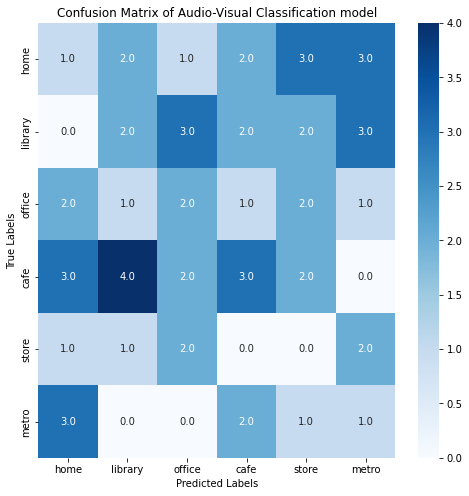

In [26]:
test_predicted2 = np.argmax(test_predictions, axis = 1)
test_true2 = np.argmax(audio_Y_test2_cat, axis = 1)
confmx2 = confusion_matrix(test_predicted2, test_true2)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx2, annot=True, fmt='.1f', ax = ax, cmap = 'Blues')
labels = ['home', 'library', 'office', 'cafe', 'store', 'metro']
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.title('Confusion Matrix of Audio-Visual Classification model')
#plt.savefig('CF_fusion2.jpg')
plt.show();